This file iterates through UMich's XML files that contain the raw transcription for EEBO to identify italicized markups.

Author: Jerry Zou

In [30]:
from bs4 import BeautifulSoup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [10]:
# This function grabs all 
folderPath = "/Users/Jerry/Desktop/A0"
fileNameList = []
def findAllFileNames(folderPathname):
    for fileName in os.listdir(folderPathname):
        if fileName.endswith(".xml"):
            fileTitle = os.path.join(folderPath, fileName)
            fileNameList.append(fileTitle)
findAllFileNames(folderPath)
print(fileNameList)

['/Users/Jerry/Desktop/A0/A07873.P4.xml', '/Users/Jerry/Desktop/A0/A01467.P4.xml', '/Users/Jerry/Desktop/A0/A00601.P4.xml', '/Users/Jerry/Desktop/A0/A01567.P4.xml', '/Users/Jerry/Desktop/A0/A08911.P4.xml', '/Users/Jerry/Desktop/A0/A06400.P4.xml', '/Users/Jerry/Desktop/A0/A07666.P4.xml', '/Users/Jerry/Desktop/A0/A09462.P4.xml', '/Users/Jerry/Desktop/A0/A07380.P4.xml', '/Users/Jerry/Desktop/A0/A06500.P4.xml', '/Users/Jerry/Desktop/A0/A06251.P4.xml', '/Users/Jerry/Desktop/A0/A07280.P4.xml', '/Users/Jerry/Desktop/A0/A08704.P4.xml', '/Users/Jerry/Desktop/A0/A09233.P4.xml', '/Users/Jerry/Desktop/A0/A04006.P4.xml', '/Users/Jerry/Desktop/A0/A03925.P4.xml', '/Users/Jerry/Desktop/A0/A03825.P4.xml', '/Users/Jerry/Desktop/A0/A05360.P4.xml', '/Users/Jerry/Desktop/A0/A03730.P4.xml', '/Users/Jerry/Desktop/A0/A04942.P4.xml', '/Users/Jerry/Desktop/A0/A08128.P4.xml', '/Users/Jerry/Desktop/A0/A02456.P4.xml', '/Users/Jerry/Desktop/A0/A00969.P4.xml', '/Users/Jerry/Desktop/A0/A03002.P4.xml', '/Users/Jerry/D

In [17]:
xmlFilePath = "/Users/Jerry/Desktop/A0/A00002.P4.xml"
with open(xmlFilePath, "r") as file:
    content = file.readlines()
lineNumberAndContent = []
for lineNumber, lineContent in enumerate(content, start=1):
    soupContent = BeautifulSoup(lineContent, "xml")
    HITag = soupContent.find_all("HI")
    for tag in HITag:
        lineNumberAndContent.append((lineNumber, tag.text))
for line_number, text in lineNumberAndContent:
    print(f'Line {line_number}: {text}')

Line 35: Viz.
Line 38: This is life eternall, that they may know thee the onely true God, and Iesus Christ whom thou hast sent.
Line 64: Maynards
Line 71: London,
Line 73: me
Line 73: Fauour,
Line 73: thee
Line 74: mee
Line 75: Graces fiue
Line 75: thee
Line 77: Almener
Line 78: Bounty;
Line 78: thee
Line 79: large spirit,
Line 79: zeale
Line 80: Temples
Line 80: head
Line 80: sides
Line 81: Knowledge
Line 82: Schooles,
Line 82: Church
Line 83: Vertues:
Line 84: Graces
Line 84: thee
Line 85: spirituall Ioy;
Line 86: thee
Line 88: Your Lordships bounden in all dutie and seruice,
Line 95: MOst honor'd & belou'd! Enquire you why
Line 96: A
Line 96: meddles with
Line 97: I diue no
Line 97: of disputation,
Line 98: But wade in
Line 98: of
Line 99: I write no
Line 99: no
Line 100: No
Line 100: nor
Line 101: Nor whither
Line 101: by
Line 101: are due,
Line 102: Or doe to
Line 102: by
Line 102: accrew:
Line 103: These
Line 103: I leaue to
Line 104: That searched haue profundest
Line 106: I hat

In [20]:
listRemovedShortItalics = []
for tuple in lineNumberAndContent:
    if len(tuple[1]) > 30:
        listRemovedShortItalics.append(tuple)
for line_number, text in listRemovedShortItalics:
    print(f'Line {line_number}: {text}')

Line 38: This is life eternall, that they may know thee the onely true God, and Iesus Christ whom thou hast sent.
Line 88: Your Lordships bounden in all dutie and seruice,
Line 95: MOst honor'd & belou'd! Enquire you why
Line 106: I hate; my mind I onely exercise
Line 175: th'vnderstandings sound determination,
Line 178: Creatures, first, and latter Testament,
Line 185: Gods Wisdome, Goodnesse; Power, and Prouidence,
Line 208: Gods will particular, and generall,
Line 245: Law, History, Arts, Physicke, Poetrie;
Line 260: Knowledge of God and Christ the Sauiour
Line 372: Obedience, Passion, Resurrection, Exaltation.
Line 531: Milke, Hony, liuing Water, spiced Wine;
Line 542: nauell, belly, head, necke, brests
Line 687: Faith, Knowledge, Patience, Fortitude,
Line 737: Schismes in Church, in Common-wealth Commotion;
Line 761: Where's my belou'd? Ah whither is shee gone?
Line 1011: touch, tongue, smell, eye, eare,
Line 1052: Loue, Peace, Concord, Pudour Virginall,
Line 1053: Gentlenesse, Me

----
Content below are visualization tests:

In [45]:
lineNumberList = [int(tuple[0]) for tuple in listRemovedShortItalics]
print(len(lineNumberList))
lineRandom = random.sample(range(1, 5441), 55)
print(lineRandom)

55
[4224, 4613, 4979, 2484, 4225, 1293, 3165, 4742, 4232, 2110, 5236, 3559, 4726, 2337, 717, 3733, 5054, 3059, 996, 4113, 3928, 1302, 160, 5369, 3138, 4518, 2778, 484, 3519, 1146, 870, 42, 1790, 537, 2396, 2020, 676, 2365, 2783, 5267, 1686, 3444, 404, 2494, 1518, 68, 920, 2768, 2402, 2282, 1277, 208, 2948, 4704, 1401]


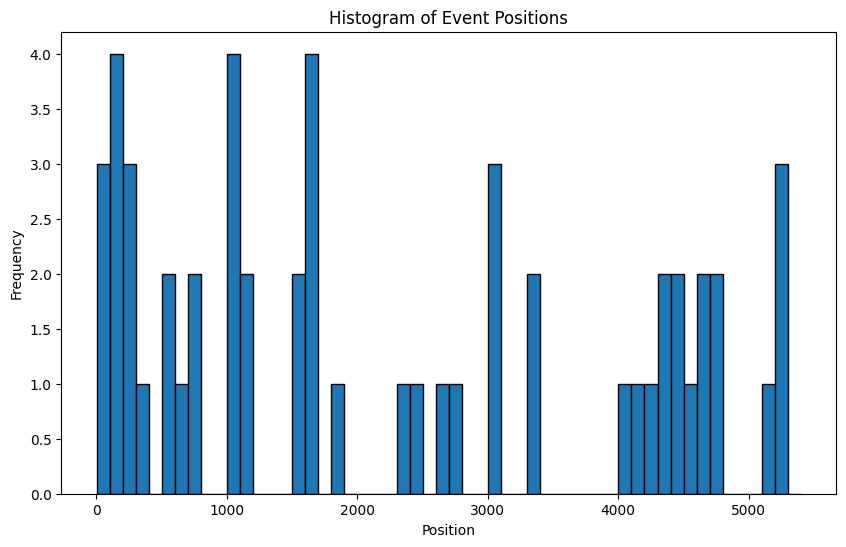

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(lineNumberList, bins=range(1, 5440, 100), edgecolor='black')
plt.title('Histogram of Event Positions')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.show()

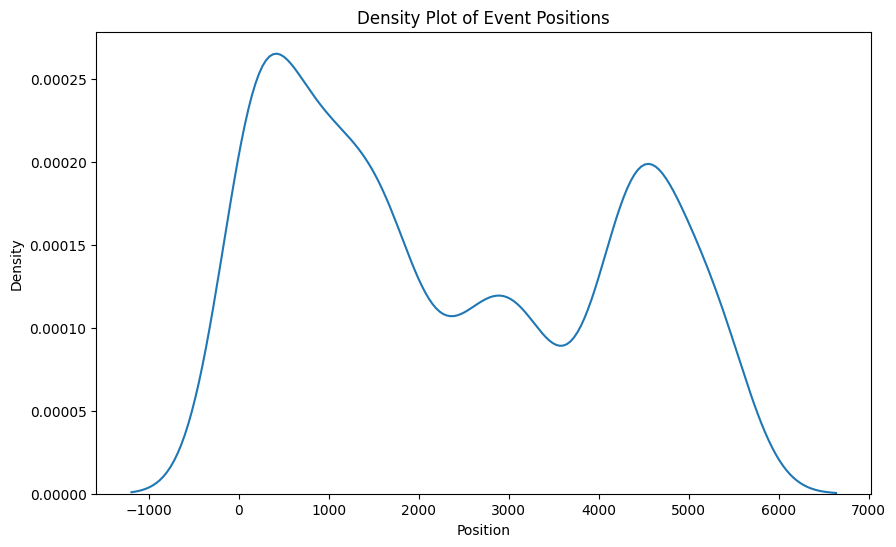

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lineNumberList, bw_adjust=0.5)
plt.title('Density Plot of Event Positions')
plt.xlabel('Position')
plt.ylabel('Density')
plt.show()

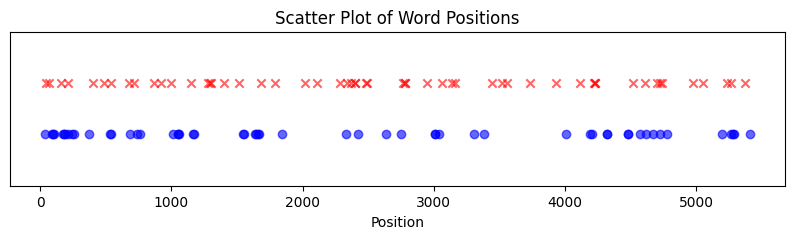

In [54]:
plt.figure(figsize=(10, 2))
plt.scatter(lineNumberList, [1] * len(lineNumberList), alpha=0.6, label='Set 1', color='blue', marker='o')
plt.scatter(lineRandom, [2] * len(lineRandom), alpha=0.6, label='Set 2', color='red', marker='x')
plt.title('Scatter Plot of Word Positions')
plt.xlabel('Position')
plt.ylim(0, 3)
plt.yticks([])
plt.show()

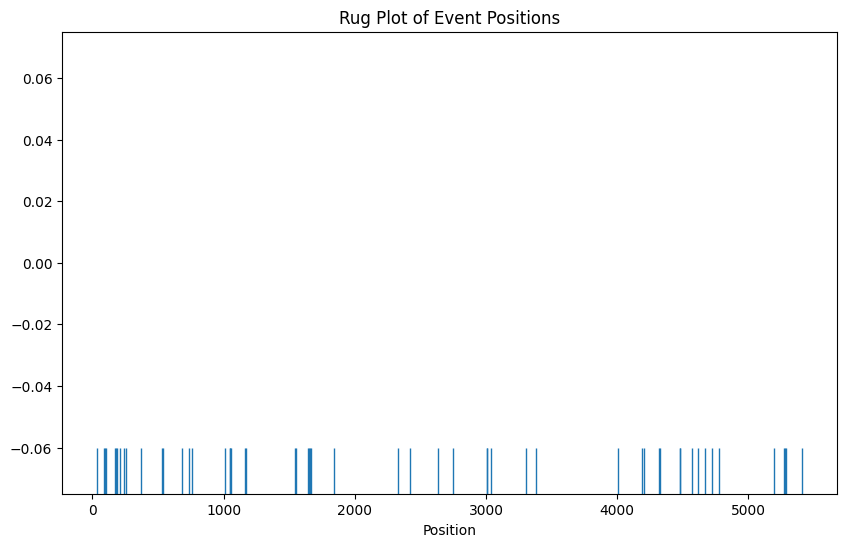

In [27]:
plt.figure(figsize=(10, 6))
sns.rugplot(lineNumberList, height=0.1)
plt.title('Rug Plot of Event Positions')
plt.xlabel('Position')
plt.show()

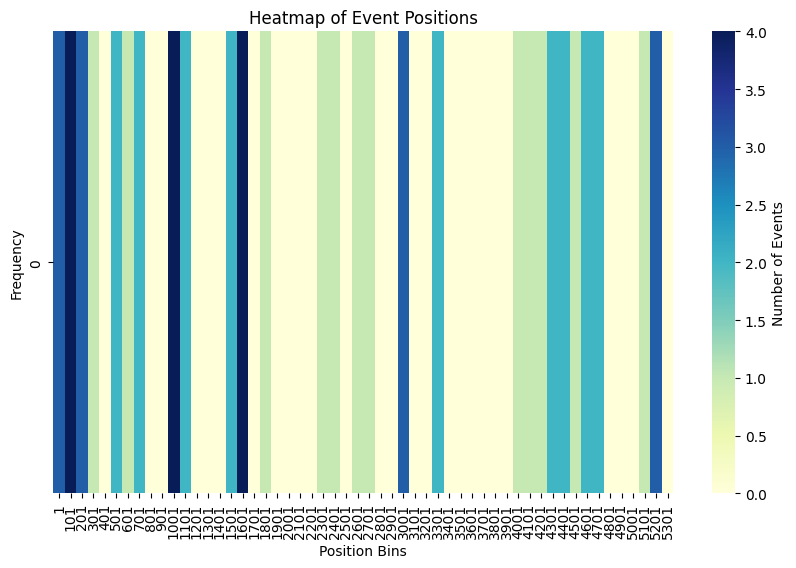

In [28]:
# Create bins
bin_size = 100
bins = range(1, 5440, bin_size)
event_counts, _ = np.histogram(lineNumberList, bins=bins)

plt.figure(figsize=(10, 6))
sns.heatmap([event_counts], cmap="YlGnBu", cbar_kws={'label': 'Number of Events'})
plt.title('Heatmap of Event Positions')
plt.xlabel('Position Bins')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(len(bins)-1) + 0.5, labels=bins[:-1], rotation=90)
plt.show()
